In [1]:
import os
import sys
sys.path.append(os.path.join(os.pardir, os.pardir))

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as F_transforms
import torchinfo

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from amlutils.task3 import UNet, load_zipped_pickle, save_zipped_pickle, visualize_segmentation, generate_augmented_data

comet_ml is installed but `COMET_API_KEY` is not set.


In [3]:
# CHANGE DIRECTORY
data_dir = os.path.join(os.pardir, 'data')

# Padding

In [ ]:
a = np.array(
    [[1,2],
    [3,4]]
)
np.pad(a, [(8,8), (8,8)])

In [ ]:
torch.tensor(
    [
        [1,2],
        [3,4]
    ]
) ** 2

In [ ]:
a = torch.tensor(
    [
        [1,2],
        [3,4]
    ]
)
b = torch.tensor(
    [
        [5,5,5],
        [5,5,5],
        [5,5,5]
    ]
)
torch.concat([b, a], dim=0)

In [ ]:
a = torch.tensor(
    [
        [1,2],
        [3,4]
    ]
)
F_transforms.pad(a, [8,8,8,8])

In [ ]:
train = load_zipped_pickle(os.path.join(data_dir, 'train.pkl'))
train

In [ ]:
expert_train = [sample for sample in train if sample['dataset'] == 'expert']
print(len(expert_train))
print(expert_train[0].keys())

In [ ]:
expert_train_shapes = [sample['box'].shape for sample in expert_train]
print(expert_train_shapes)
print(max([shape[0] for shape in expert_train_shapes]))
print(max([shape[1] for shape in expert_train_shapes]))

In [ ]:
809 // 32

In [ ]:
26 * 32

In [ ]:
for i in range(64):
    print(f'{i}: {(809 + i) % 32}')

# Boxes

In [ ]:
expert_train_sample = expert_train[0]
labeled_frame = expert_train_sample['frames'][0]
expert_train_frame = expert_train_sample['video'][:,:,labeled_frame]
expert_train_label = expert_train_sample['label'][:,:,labeled_frame]
expert_train_box = expert_train_sample['box']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.imshow(expert_train_frame)
ax.imshow(expert_train_label, alpha=0.5)
ax.imshow(expert_train_box, alpha=0.25)

plt.show()

In [ ]:
box_tensor = torch.tensor(expert_train_box, dtype=torch.float)
box_tensor

In [ ]:
epsilon = 0.01
torch.where(box_tensor == 0, torch.ones(box_tensor.shape) * (1/epsilon), torch.ones(box_tensor.shape) * epsilon)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

expert_train = [sample for sample in train if sample['dataset'] == 'expert']
box_tensor_list = [torch.tensor(sample['box'], dtype=torch.float) for sample in expert_train]
min_width = min([tensor.shape[0] for tensor in box_tensor_list])
min_height = min([tensor.shape[1] for tensor in box_tensor_list])
box_tensor_list = [F_transforms.center_crop(tensor, (min_width, min_height)) for tensor in box_tensor_list]
union_box = torch.stack(box_tensor_list, dim=0).sum(dim=0)
ax[0].imshow(union_box)
ax[0].set_title("Overlapped Bounding Boxes, Expert Images")

threshold = 5

overlap_box = torch.where(
    union_box >= threshold,
    torch.ones(union_box.shape),
    torch.zeros(union_box.shape),
)

ax[1].imshow(overlap_box)
ax[1].set_title(f"Area with >={threshold} Overlapping BBs, Expert Images")

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

expert_train = [sample for sample in train if sample['dataset'] == 'amateur']
box_tensor_list = [torch.tensor(sample['box'], dtype=torch.float) for sample in expert_train]
min_width = min([tensor.shape[0] for tensor in box_tensor_list])
min_height = min([tensor.shape[1] for tensor in box_tensor_list])
box_tensor_list = [F_transforms.center_crop(tensor, (min_width, min_height)) for tensor in box_tensor_list]
union_box = torch.stack(box_tensor_list, dim=0).sum(dim=0)
ax[0].imshow(union_box)
ax[0].set_title("Overlapped Bounding Boxes, Amateur Images")

threshold = 5

overlap_box = torch.where(
    union_box >= threshold,
    torch.ones(union_box.shape),
    torch.zeros(union_box.shape),
)

ax[1].imshow(overlap_box)
ax[1].set_title(f"Area with >={threshold} Overlapping BBs, Amateur Images")

plt.show()

# Data Augmentation

In [4]:
train = load_zipped_pickle(os.path.join(data_dir, 'train.pkl'))
expert_train = [sample for sample in train if sample['dataset'] == 'expert']
expert_train

[{'name': '11NZLRCO13',
  'video': array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],

In [6]:
expert_train_sample = expert_train[0]
labeled_frame = expert_train_sample['frames'][0]
expert_train_frame = expert_train_sample['video'][:,:,labeled_frame]
expert_train_label = expert_train_sample['label'][:,:,labeled_frame]
expert_train_box = expert_train_sample['box']

In [7]:
def pad_to_multiple(array: np.ndarray, n: int) -> np.ndarray:
    """Pad array to have width and height as multiple of given number."""
    original_height, original_width = array.shape

    next_multiple = lambda x: ((x // n) + 1) * n

    new_height = next_multiple(original_height) - original_height
    new_width = next_multiple(original_width) - original_width

    return np.pad(array, ((0, new_height), (0, new_width)))

In [8]:
frames, labels, boxes = generate_augmented_data(
    pad_to_multiple(expert_train_frame, 2**5),
    pad_to_multiple(expert_train_label, 2**5),
    pad_to_multiple(expert_train_box, 2**5)
)

In [9]:
labels

{'original': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'rotated': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'translated': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'sheared': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 

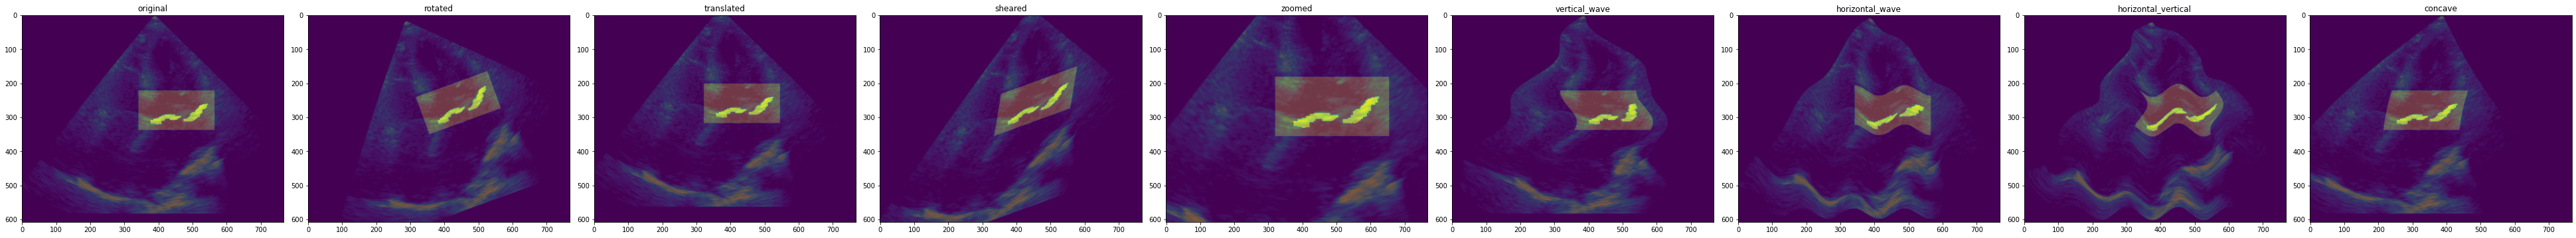

In [37]:
n_transforms = len(frames)
fig, ax = plt.subplots(1, n_transforms, figsize=(6 * n_transforms, 6))
fig.set_facecolor('white')

for index, transformation in enumerate(frames.keys()):
    visualize_segmentation(
        ax[index],
        frames[transformation].numpy()[0,:,:],
        labels[transformation].numpy(),
        segmentation_opacity=0.5
    )
    ax[index].imshow(boxes[transformation], alpha=0.25)
    ax[index].set_title(f'{transformation}')

plt.tight_layout()
plt.show()

# Construct Augmented Data Set

In [10]:
train = load_zipped_pickle(os.path.join(data_dir, 'train.pkl'))
expert_train = [sample for sample in train if sample['dataset'] == 'expert']
expert_train

[{'name': '11NZLRCO13',
  'video': array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],

In [12]:
augmented_data = []

for index, sample in enumerate(expert_train):
    for labelled_frame in sample['frames']:
        frame = sample['video'][:,:,labelled_frame]
        label = sample['label'][:,:,labelled_frame]
        box = sample['box']

        frames, labels, boxes = generate_augmented_data(
            pad_to_multiple(frame, 2**5),
            pad_to_multiple(label, 2**5),
            pad_to_multiple(box, 2**5)
        )

        for transformation in frames.keys():
            augmented_data.append(
                {
                    'frame': frames[transformation],
                    'label': labels[transformation],
                    'box': boxes[transformation]
                }
            )
    print(f'Finished expert train sample {index + 1}')

Finished expert train sample 1
Finished expert train sample 2
Finished expert train sample 3
Finished expert train sample 4
Finished expert train sample 5
Finished expert train sample 6
Finished expert train sample 7
Finished expert train sample 8
Finished expert train sample 9
Finished expert train sample 10
Finished expert train sample 11
Finished expert train sample 12
Finished expert train sample 13
Finished expert train sample 14
Finished expert train sample 15
Finished expert train sample 16
Finished expert train sample 17
Finished expert train sample 18
Finished expert train sample 19


In [13]:
save_zipped_pickle(augmented_data, os.path.join(os.pardir, 'data', 'augmented-expert-train.pkl'))

In [14]:
augmented_expert_train = load_zipped_pickle(os.path.join(os.pardir, 'data', 'augmented-expert-train.pkl'))
augmented_expert_train

[{'frame': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'label': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
  'box': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)},
 {'frame': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],


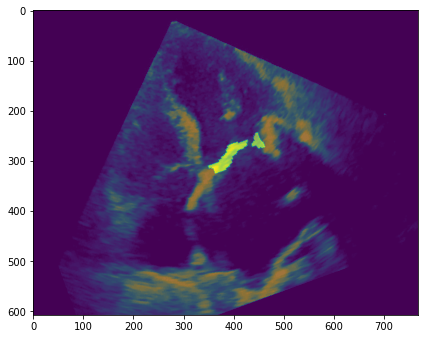

In [15]:
sample = 217
fig, ax = plt.subplots(1, 1, figsize=(6,6))

visualize_segmentation(
    ax,
    augmented_expert_train[sample]['frame'].numpy()[0,:,:],
    augmented_expert_train[sample]['label'].numpy(),
    segmentation_opacity=0.5
)
#ax.imshow(augmented_expert_train[sample]['box'].numpy(), alpha=0.25)

plt.tight_layout()
plt.show()

# Segment Image

In [ ]:
image = convert_to_tensor(train_set[0]['Image'])
image = torch.unsqueeze(image, 0)
segmentation = mv_segmenter(image)
segmentation = torch.squeeze(segmentation)
segmentation.shape

In [ ]:
prediction = F.softmax(segmentation, dim=0)
print(prediction.shape)
prediction = torch.max(prediction, dim=0).indices
prediction = torch.squeeze(prediction)#.detach().numpy()
#prediction = prediction[0,:,:].detach().numpy()
prediction

In [ ]:
prediction = F.softmax(segmentation, dim=0)
print(torch.min(prediction[0,:,:]))
prediction = torch.round(prediction[1,:,:]).detach().numpy()
np.max(prediction)

In [ ]:
prediction = F.softmax(segmentation, dim=0)
prediction = torch.where(prediction[1,:,:] > 0.29, torch.ones(prediction.shape[1:]), torch.zeros(prediction.shape[1:])).numpy()
prediction

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.set_facecolor('white')

cropped_image = F_transforms.center_crop(image, prediction.shape[1:])
cropped_label = F_transforms.center_crop(torch.tensor(train_set[0]['Label']), prediction.shape[1:]).numpy()
cropped_image = torch.squeeze(cropped_image)
cropped_image = torch.squeeze(cropped_image).numpy()

visualize_segmentation(ax[0], cropped_image, prediction, segmentation_opacity=0.5)
ax[0].set_title('U-Net Predicted Segmentation (P[Is MV]>0.29)')

visualize_segmentation(ax[1], cropped_image, cropped_label, segmentation_opacity=0.5)
ax[1].set_title('Ground Truth')

plt.tight_layout()
plt.show()

# Inspect Training Set

In [ ]:
train_set = load_zipped_pickle(os.path.join(data_dir, 'labeled-images.pkl'))

In [ ]:
visualize_segmentation(train_set[0]['Image'], train_set[0]['Label'])

In [ ]:
train_input = torch.from_numpy(train_set[0]['Image'])
train_input = torch.unsqueeze(train_input, 0)
torchinfo.summary(UNet(), input_size=(1, *train_input.shape))

In [ ]:
visualize_segmentation(
    F_transforms.center_crop(torch.from_numpy(train_set[0]['Image']), prediction.shape).numpy(),
    F_transforms.center_crop(torch.from_numpy(train_set[0]['Label']), prediction.shape).numpy()
)

In [ ]:
tens = F_transforms.center_crop(torch.from_numpy(train_set[0]['Image']), (60, 60))
#torch.stack([tens, tens], dim=2).shape
tens = torch.unsqueeze(tens, dim=2)
torch.concat([tens, tens], dim=2).shape